In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
df = pd.read_csv('/content/drive/My Drive/FakeNews-Dataset/full_database.csv')

In [ ]:
#!pip install fuzzywuzzy
#!pip install tweepy
import os
import nltk
nltk.download('rslp')
nltk.download('stopwords')
nltk.download('punkt')
import tweepy
import string
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from fuzzywuzzy import fuzz
from time import time, sleep
from nltk.corpus import stopwords 
from sklearn.svm import OneClassSVM
from nltk.tokenize import word_tokenize
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, precision_score,recall_score,roc_curve, auc,roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.cluster import KMeans
from sklearn.preprocessing import normalize
from scipy.stats import ttest_1samp,ttest_ind, ttest_rel, norm

[nltk_data] Downloading package rslp to /root/nltk_data...
[nltk_data]   Package rslp is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [ ]:
def web_scrapping():
  consumer_key = 'A0iOlLQR7YE2Pp0AtCsug5X9y'
  consumer_secret = 'boQx4ohmC1N0dpElF9qNwnis0qmuEVgix1xTSCy1TbLzjjeIDy'
  access_key= '1173637793379160067-KnsE82lVbhpaFZwFs3TGxWcwuaPEdy'
  access_secret = 'alHVYz6EJuspq3SCCbphq8y2i929WkkfCvjttQbFsEr0N'
  auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
  auth.set_access_token(access_key, access_secret)
  api = tweepy.API(auth)
  
  account = '@Boatosorg'
  file_path ="boatos.csv"
  batch=10
  
  df = pd.DataFrame(columns=['id', 'created_at', 'source','user','full_text'])
  for status in tweepy.Cursor(api.user_timeline, screen_name=account, include_rts=False, lang="pt", tweet_mode="extended").items(batch):
    status = status._json
    #print (status.keys())
    new_entry = []
    new_entry += [status['id'], status['created_at'],status['source'],status['user']['screen_name'], status['full_text']]
    
    single_tweet_df = pd.DataFrame([new_entry],columns=df.columns)
    df = pd.concat([df, single_tweet_df])
  return df

In [ ]:
def check_limits():
  consumer_key = 'A0iOlLQR7YE2Pp0AtCsug5X9y'
  consumer_secret = 'boQx4ohmC1N0dpElF9qNwnis0qmuEVgix1xTSCy1TbLzjjeIDy'
  access_key= '1173637793379160067-KnsE82lVbhpaFZwFs3TGxWcwuaPEdy'
  access_secret = 'alHVYz6EJuspq3SCCbphq8y2i929WkkfCvjttQbFsEr0N'
  auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
  auth.set_access_token(access_key, access_secret)
  api = tweepy.API(auth)
  limits=api.rate_limit_status()
  for i in limits['resources'].keys():
    for k in limits['resources'][i].keys(): 
      if limits['resources'][i][k]['limit']!=limits['resources'][i][k]['remaining']:
        reset_time=float(limits['resources'][i][k]['reset'])-time()
        remain=int(limits['resources'][i][k]['limit'])-int(limits['resources'][i][k]['remaining'])
        max_limit=limits['resources'][i][k]['limit']
        print('---- Status com Limite Modificado---------')
        print (limits['resources'][i])
        print("Falta "+str(reset_time/60)+' min para o próximo reset')
        print('Capacidade comprometida '+str(int(remain)/int(max_limit)))

In [ ]:
def remove_punctuation(word):

	word = word.replace('-via', '')
	word = word.replace('(via', '')
	word = word.replace('gt', '')
	for ch in string.punctuation:
		word = word.replace(ch, "")
	if(len(word) < 2 or word.isdigit()):
		return ""
	return word

def similarity(word, names):

	try:
		for w in names[word[0]]:
			if(fuzz.ratio(w, word) > 80):
				return True
	except KeyError:
		pass
	return False

def get_name_dict():

	names = open('/content/drive/My Drive/FakeNews-Dataset/names.txt', encoding="utf-8")
	names_lines = names.readlines()
	names_dict = {}
	for lines in names_lines:
		line = lines.replace('\n','').lower()
		if line[0] not in names_dict: names_dict[line[0]] = []
		names_dict[line[0]].append(line)
	return names_dict

def natural_language_processing(df):
  stemmer = nltk.stem.RSLPStemmer()
  stop_words = set(stopwords.words('portuguese'))
  names_dict=get_name_dict()
  
  df.loc[df["user"] == "Boatosorg", "label"] = -1
  df.loc[df["user"] != "Boatosorg", "label"] = 1 
  #print (df.shape)
  #df = df.head(2000)
  df["clean_text"] = df["full_text"].str.lower()
  df["clean_text"] = df["clean_text"].apply(lambda x:' '.join(remove_punctuation(word) for word in word_tokenize(str(x))))
  df["clean_text"] = df["clean_text"].apply(lambda x:' '.join(word for word in word_tokenize(x) if word not in stop_words))
  df["clean_text"] = df["clean_text"].apply(lambda x:' '.join(stemmer.stem(word) for word in word_tokenize(x) if not similarity(word, names_dict)))
  print(df)
  

In [ ]:
df=web_scrapping()
natural_language_processing(df)

In [ ]:
df = pd.read_csv('/content/drive/My Drive/FakeNews-Dataset/full_database.csv')
df=df.head(10000)
tfidf_vectorizer = TfidfVectorizer(ngram_range=(1,1))
tfidf_matrix=tfidf_vectorizer.fit_transform(df["clean_text"].values.astype('U'))

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (0,6,7,9,10,12) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [ ]:
svd = TruncatedSVD(n_components=2000)
tfidf_lsa = svd.fit_transform(tfidf_matrix)
tfidf_lsa=normalize(tfidf_lsa.T)
tfidf_lsa=tfidf_lsa.T

In [ ]:
print("OneClassSVM...")
df_x = pd.DataFrame(tfidf_lsa[0:,0:])
X_train, X_test, y_train, y_test = train_test_split(df_x, df['probability'][0:], test_size=0.1)
train_normal=X_train.loc[df["probability"] == 1]
train_outliers = X_train.loc[df["probability"] == -1]
outlier_prop = len(train_outliers)/len(df_x)

gama=0.01
ker='linear'
print ('gama:'+ str(gama))
print ('kernel:'+ str(ker))

OneClassSVM...
gama:0.01
kernel:linear


In [ ]:
clf = OneClassSVM(nu=outlier_prop, kernel=ker,gamma=gama, degree=5)
clf.fit(train_normal)
y_pred = clf.predict(X_test)

[0.7959909  0.80872856 0.83599285 0.82291291 0.61401268 0.75891456
 0.80812432 0.85350148 0.80907317 0.65727602 0.76272712 0.80767643
 0.7992678  0.76252912 0.75623817 0.93284643 0.58931752 0.61655355
 0.84710305 0.85110222 0.78270552 0.62771632 0.84964877 0.58964563
 0.92047643 0.84776332 0.8779943  1.         0.74978668 0.69158246
 0.79396236 0.82776597 0.84189709 0.79720044 0.60087879 0.82624192
 0.81278331 0.80883542 0.69095273 0.62660384 0.82572314 0.55512948
 0.93471045 0.80684601 0.81242626 0.8399686  0.88493852 0.79293153
 0.62875977 0.77640594 0.80926936 0.73463605 0.84420366 0.70661464
 0.76319801 0.8092055  0.84148745 0.81416816 0.71473252 0.82739801
 0.76782361 0.75490229 0.80865424 0.77669008 0.81918218 0.80878283
 0.78558459 0.90082132 0.9179129  0.60230357 0.78524981 0.85775775
 0.61758411 0.84551251 0.65197736 0.78757804 0.80924904 0.67541066
 0.70892603 0.69676068 0.80875319 0.7924959  0.71831181 0.84243955
 0.87297101 0.83669226 0.69277757 0.82830969 0.71089073 0.7533

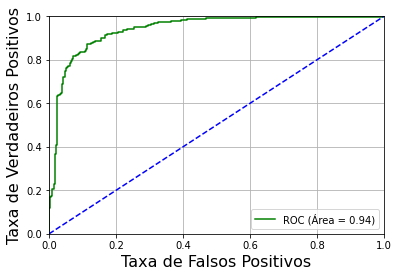

Acurácia: 0.664
Recall: [0.97682119 0.5286533 ]
Precisão: [0.47275641 0.98138298]
F1-Score: 0.6871508379888268


In [ ]:
probabilidades=[]
true=[]

probabilidades = max(clf.decision_function(X_test)) - clf.decision_function(X_test)
for i in range(len(probabilidades)):probabilidades[i]=1-probabilidades[i]
print(probabilidades)
fpr, tpr, thresholds = roc_curve(y_test, probabilidades)
roc_auc = auc(fpr, tpr)
g=plt.figure(3)
plt.rcParams['axes.labelsize']= 16
plt.plot(fpr, tpr, label='ROC (Área = %0.2f)' % roc_auc,color='green')
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'b--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('Taxa de Verdadeiros Positivos')
plt.xlabel('Taxa de Falsos Positivos')
plt.grid(True)
plt.show()

print ("Acurácia: " + str(accuracy_score(y_test,y_pred)))
print ("Recall: " + str(recall_score(y_test,y_pred,average=None,)))
print ("Precisão: " + str(precision_score(y_test,y_pred,average=None)))
print ("F1-Score: " + str(f1_score(y_test,y_pred)))